# Cumulative Sum Prediction

This is the fifth toy example from Jason Brownlee's [Long Short Term Memory Networks with Python](https://machinelearningmastery.com/lstms-with-python/). It demonstrates the solution to a sequence-to-sequence (aka seq2seq) prediction problem. Per section 10.2 of the book:

> The problem is defined as a sequence of random values between 0 and 1. This sequence is taken as input for the problem with each number provided once per time step. A binary label (0 or 1) is associated with each input. The output values are initially all 0. Once the cumulative sum of the input values in the sequence exceeds a threshold, then the output value  flips from 0 to 1. A threshold of one quarter (1/4) of the sequence length is used, so for a sequence of length 10, the threshold is 2.5.

> We will frame the problem to make the best use of the Bidirectional LSTM architecture.
The output sequence will be produced after the entire input sequence has been fed into the
model. Technically, this means this is a sequence-to-sequence prediction problem that requires
a many-to-many prediction model. It is also the case that the input and output sequences have
the same number of time steps (length).

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
MODEL_FILE = os.path.join(DATA_DIR, "torch-10-cumsum-predict-{:d}.model")

TRAIN_SIZE = 7500
VAL_SIZE = 100
TEST_SIZE = 500

SEQ_LENGTH = 10
EMBED_SIZE = 1

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

## Prepare Data

In [3]:
def generate_sequence(seq_len):
    xs = np.random.random(seq_len)
    ys = np.array([0 if x < 2.5 else 1 for x in np.cumsum(xs).tolist()])
    return xs, ys

X, Y = generate_sequence(SEQ_LENGTH)
print(X)
print(Y)

[ 0.04742344  0.93090249  0.47292869  0.34986938  0.27752548  0.22485943
  0.05711298  0.38595953  0.78495727  0.13500855]
[0 0 0 0 0 0 0 1 1 1]


In [4]:
def generate_data(seq_len, num_seqs):
    xseq, yseq = [], []
    for i in range(num_seqs):
        X, Y = generate_sequence(seq_len)
        xseq.append(X)
        yseq.append(Y)
    return np.expand_dims(np.array(xseq), axis=2), np.array(yseq)

Xtrain, Ytrain = generate_data(SEQ_LENGTH, TRAIN_SIZE)
Xval, Yval = generate_data(SEQ_LENGTH, VAL_SIZE)
Xtest, Ytest = generate_data(SEQ_LENGTH, TEST_SIZE)

print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, Xtest.shape, Ytest.shape)

(7500, 10, 1) (7500, 10) (100, 10, 1) (100, 10) (500, 10, 1) (500, 10)


## Define Network

The sequence length for the input and output sequences are the same size. Our network follows the model built (using Keras) in the book. Unlike the typical encoder-decoder LSTM architecture that is used for most seq2seq problems, here we have a single LSTM followed by a FCN layer at each timestep of its output. Each FCN returns a binary 0/1 output, which is concatenated to produce the predicted result.

In [5]:
class CumSumPredictor(nn.Module):
    
    def __init__(self, seq_len, input_dim, hidden_dim, output_dim):
        super(CumSumPredictor, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # network layers
        self.enc_lstm = nn.LSTM(input_dim, hidden_dim, 1, batch_first=True, 
                                bidirectional=True)
        self.fcn = nn.Linear(hidden_dim * 2, output_dim)  # bidirectional input
        self.fcn_relu = nn.ReLU()
        self.fcn_softmax = nn.Softmax()
    
    def forward(self, x):
        if torch.cuda.is_available():
            h = (Variable(torch.randn(2, x.size(0), self.hidden_dim).cuda()),
                 Variable(torch.randn(2, x.size(0), self.hidden_dim).cuda()))
        else:
            h = (Variable(torch.randn(2, x.size(0), self.hidden_dim)),
                 Variable(torch.randn(2, x.size(0), self.hidden_dim)))

        x, h = self.enc_lstm(x, h)       # encoder LSTM
        x_fcn = Variable(torch.zeros(x.size(0), self.seq_len, self.output_dim))
        for i in range(self.seq_len):    # decoder LSTM -> fcn for each timestep
            x_fcn[:, i, :] = self.fcn_softmax(self.fcn_relu(self.fcn(x[:, i, :])))
        x = x_fcn        
        return x
    
model = CumSumPredictor(SEQ_LENGTH, EMBED_SIZE, 50, 2)
if torch.cuda.is_available():
    model.cuda()
print(model)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE))
outp = model(inp)
print(outp.size())

CumSumPredictor (
  (enc_lstm): LSTM(1, 50, batch_first=True, bidirectional=True)
  (fcn): Linear (100 -> 2)
  (fcn_relu): ReLU ()
  (fcn_softmax): Softmax ()
)
--- size debugging ---
torch.Size([32, 10, 2])


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [7]:
def compute_accuracy(pred_var, true_var):
    if torch.cuda.is_available():
        ypred = pred_var.cpu().data.numpy()
        ytrue = true_var.cpu().data.numpy()
    else:
        ypred = pred_var.data.numpy()
        ytrue = true_var.data.numpy()
    pred_nums, true_nums = [], []
    for i in range(pred_var.size(0)): # for each row of output
        pred_nums.append(int("".join([str(x) for x in ypred[i].tolist()]), 2))
        true_nums.append(int("".join([str(x) for x in ytrue[i].tolist()]), 2))
    return pred_nums, true_nums, accuracy_score(pred_nums, true_nums)


history = []
for epoch in range(NUM_EPOCHS):
    
    num_batches = Xtrain.shape[0] // BATCH_SIZE
    shuffled_indices = np.random.permutation(np.arange(Xtrain.shape[0]))
    train_loss, train_acc = 0., 0.
    
    for bid in range(num_batches):
        
        # extract one batch of data
        Xbatch_data = Xtrain[shuffled_indices[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]]
        Ybatch_data = Ytrain[shuffled_indices[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            Ybatch = Ybatch.cuda()
        
        # initialize gradients
        optimizer.zero_grad()

        # forward
        loss = 0.
        Ybatch_ = model(Xbatch)
        for i in range(Ybatch.size(1)):
            loss += loss_fn(Ybatch_[:, i, :], Ybatch[:, i])
        
        # backward
        loss.backward()

        train_loss += loss.data[0]
        
        _, ybatch_ = Ybatch_.max(2)
        _, _, acc = compute_accuracy(ybatch_, Ybatch)
        train_acc += acc
        
        optimizer.step()
        
    # compute training loss and accuracy
    train_loss /= num_batches
    train_acc /= num_batches
    
    # compute validation loss and accuracy
    val_loss, val_acc = 0., 0.
    num_val_batches = Xval.shape[0] // BATCH_SIZE
    for bid in range(num_val_batches):
        # data
        Xbatch_data = Xval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        Ybatch_data = Yval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            Ybatch = Ybatch.cuda()

        loss = 0.
        Ybatch_ = model(Xbatch)
        for i in range(Ybatch.size(1)):
            loss += loss_fn(Ybatch_[:, i, :], Ybatch[:, i])
        val_loss += loss.data[0]

        _, ybatch_ = Ybatch_.max(2)
        _, _, acc = compute_accuracy(ybatch_, Ybatch)
        val_acc += acc
        
    val_loss /= num_val_batches
    val_acc /= num_val_batches
    
    torch.save(model.state_dict(), MODEL_FILE.format(epoch+1))
    print("Epoch {:2d}/{:d}: loss={:.3f}, acc={:.3f}, val_loss={:.3f}, val_acc={:.3f}"
          .format((epoch+1), NUM_EPOCHS, train_loss, train_acc, val_loss, val_acc))
    
    history.append((train_loss, val_loss, train_acc, val_acc))

Epoch  1/10: loss=4.743, acc=0.254, val_loss=4.109, val_acc=0.323
Epoch  2/10: loss=3.827, acc=0.464, val_loss=3.728, val_acc=0.510
Epoch  3/10: loss=3.640, acc=0.569, val_loss=3.647, val_acc=0.521
Epoch  4/10: loss=3.562, acc=0.627, val_loss=3.597, val_acc=0.594
Epoch  5/10: loss=3.527, acc=0.651, val_loss=3.570, val_acc=0.635
Epoch  6/10: loss=3.500, acc=0.676, val_loss=3.542, val_acc=0.667
Epoch  7/10: loss=3.484, acc=0.684, val_loss=3.496, val_acc=0.635
Epoch  8/10: loss=3.460, acc=0.706, val_loss=3.580, val_acc=0.552
Epoch  9/10: loss=3.454, acc=0.710, val_loss=3.468, val_acc=0.708
Epoch 10/10: loss=3.433, acc=0.731, val_loss=3.469, val_acc=0.719


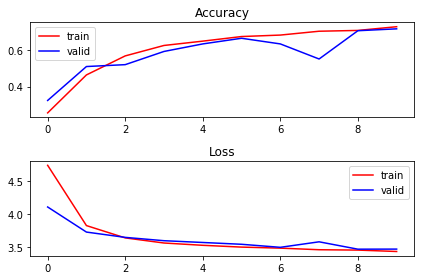

In [8]:
losses = [x[0] for x in history]
val_losses = [x[1] for x in history]
accs = [x[2] for x in history]
val_accs = [x[3] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs, color="r", label="train")
plt.plot(val_accs, color="b", label="valid")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(losses, color="r", label="train")
plt.plot(val_losses, color="b", label="valid")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [9]:
saved_model = CumSumPredictor(SEQ_LENGTH, EMBED_SIZE, 50, 2)
saved_model.load_state_dict(torch.load(MODEL_FILE.format(NUM_EPOCHS)))
if torch.cuda.is_available():
    saved_model.cuda()

In [10]:
ylabels, ypreds = [], []
num_test_batches = Xtest.shape[0] // BATCH_SIZE
for bid in range(num_test_batches):
    Xbatch_data = Xtest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Ybatch_data = Ytest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
    Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
    if torch.cuda.is_available():
        Xbatch = Xbatch.cuda()
        Ybatch = Ybatch.cuda()

    Ybatch_ = saved_model(Xbatch)
    _, ybatch_ = Ybatch_.max(2)

    pred_nums, true_nums, _ = compute_accuracy(ybatch_, Ybatch)
    ylabels.extend(true_nums)
    ypreds.extend(pred_nums)

print("Test accuracy: {:.3f}".format(accuracy_score(ylabels, ypreds)))

Test accuracy: 0.746


In [11]:
Xbatch_data = Xtest[0:10]
Ybatch_data = Ytest[0:10]
Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
if torch.cuda.is_available():
    Xbatch = Xbatch.cuda()
    Ybatch = Ybatch.cuda()

Ybatch_ = saved_model(Xbatch)
_, ybatch_ = Ybatch_.max(2)

if torch.cuda.is_available():
    ybatch__data = ybatch_.cpu().data.numpy()
else:
    ybatch__data = ybatch_.data.numpy()

for i in range(Ybatch_data.shape[0]):
    label = Ybatch_data[i]
    pred = ybatch__data[i]
    correct = "True" if np.array_equal(label, pred) else "False"
    print("y={:s}, yhat={:s}, correct={:s}".format(str(label), str(pred), correct))

y=[0 0 0 0 0 0 1 1 1 1], yhat=[0 0 0 0 0 0 1 1 1 1], correct=True
y=[0 0 0 0 0 1 1 1 1 1], yhat=[0 0 0 0 0 1 1 1 1 1], correct=True
y=[0 0 0 0 0 0 1 1 1 1], yhat=[0 0 0 0 0 0 1 1 1 1], correct=True
y=[0 0 0 0 0 0 0 1 1 1], yhat=[0 0 0 0 0 0 0 1 1 1], correct=True
y=[0 0 0 0 0 0 1 1 1 1], yhat=[0 0 0 0 0 0 1 1 1 1], correct=True
y=[0 0 0 0 0 0 1 1 1 1], yhat=[0 0 0 0 0 0 1 1 1 1], correct=True
y=[0 0 0 0 1 1 1 1 1 1], yhat=[0 0 0 0 0 1 1 1 1 1], correct=False
y=[0 0 0 0 1 1 1 1 1 1], yhat=[0 0 0 0 1 1 1 1 1 1], correct=True
y=[0 0 0 0 1 1 1 1 1 1], yhat=[0 0 0 0 1 1 1 1 1 1], correct=True
y=[0 0 0 1 1 1 1 1 1 1], yhat=[0 0 0 1 1 1 1 1 1 1], correct=True


In [12]:
for i in range(NUM_EPOCHS):
    os.remove(MODEL_FILE.format(i + 1))